<a href="https://colab.research.google.com/github/KrAryan/21BDS0018/blob/main/deepl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 CT Scan Classification using Deep Learning


# Objective:
This project aims to classify lung CT scan images into two categories:
✅ Infected (COVID-19 Positive)
✅ Non-Infected (COVID-19 Negative)

By leveraging deep learning and transfer learning, we improve the accuracy and efficiency of COVID-19 detection from medical CT scans, reducing the need for manual radiology assessments.



### Step1: install dependencies and importing libraries

In [1]:
# Install required libraries
!pip install -q kaggle
!pip install -q tensorflow tensorflow-addons
!pip install -q opencv-python-headless

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


### 📌 Step 2: Download and Extract the Dataset

In [2]:
from google.colab import files

# Upload kaggle.json manually
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumararyan13","key":"eec4eb6c324787d8efc6c98da3dff722"}'}

In [3]:
import os

# Create a .kaggle directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure file permissions


In [4]:
# Download dataset
!kaggle datasets download -d andrewmvd/covid19-ct-scans

# Extract the dataset
import zipfile

!mkdir covid19_ct_scans
with zipfile.ZipFile("covid19-ct-scans.zip", 'r') as zip_ref:
    zip_ref.extractall("covid19_ct_scans")


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/covid19-ct-scans
License(s): other
100% 1.03G/1.03G [00:13<00:00, 89.6MB/s]
100% 1.03G/1.03G [00:13<00:00, 83.6MB/s]


### 📌 3️⃣ Understanding Dataset Structure
Before we preprocess the data, let's explore the dataset.

In [6]:
import os

dataset_path = "covid19_ct_scans"
print("Dataset structure:")
for folder in os.listdir(dataset_path):
    # Check if the item is a directory before trying to list its contents
    if os.path.isdir(os.path.join(dataset_path, folder)):
        print(f"- {folder}: {len(os.listdir(os.path.join(dataset_path, folder)))} images")

Dataset structure:
- infection_mask: 20 images
- lung_and_infection_mask: 20 images
- ct_scans: 20 images
- lung_mask: 20 images


### 📌 4️⃣ Preprocessing the Data
We need to:

Resize images to 224x224.
Normalize pixel values (scale between 0-1).
Split data into training (80%) and validation (20%) sets.
Organizing Data into Train & Validation Folders
Since Kaggle's dataset doesn't come with a pre-defined train-validation split, we need to create it.

In [8]:
import shutil
import random
import os

# Create new directories
train_dir = "train"
val_dir = "val"

for category in ["Infected", "Non-infected"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to split data
def split_data(source, train_target, val_target, split_ratio=0.8):
    # Update to handle subfolders:
    for root, _, images in os.walk(source):  # Walk through subdirectories
        random.shuffle(images)
        train_size = int(len(images) * split_ratio)
        train_images = images[:train_size]
        val_images = images[train_size:]

        for img in train_images:
            shutil.copy(os.path.join(root, img), os.path.join(train_target, img))

        for img in val_images:
            shutil.copy(os.path.join(root, img), os.path.join(val_target, img))

# Perform split
dataset_path = "covid19_ct_scans"  # Make sure dataset_path is defined
for category in ["Infected", "Non-infected"]:
    split_data(
        os.path.join(dataset_path, category),
        os.path.join(train_dir, category),
        os.path.join(val_dir, category)
    )

In [14]:
import os

dataset_path = "covid19_ct_scans"
for root, dirs, files in os.walk(dataset_path):
    print(f"📂 Directory: {root}")
    for file in files[:5]:
        print(f"   📄 File: {file}")


📂 Directory: covid19_ct_scans
   📄 File: metadata.csv
📂 Directory: covid19_ct_scans/infection_mask
   📄 File: radiopaedia_14_85914_0.nii
   📄 File: coronacases_007.nii
   📄 File: coronacases_003.nii
   📄 File: coronacases_004.nii
   📄 File: radiopaedia_29_86490_1.nii
📂 Directory: covid19_ct_scans/lung_and_infection_mask
   📄 File: radiopaedia_14_85914_0.nii
   📄 File: coronacases_007.nii
   📄 File: coronacases_003.nii
   📄 File: coronacases_004.nii
   📄 File: radiopaedia_29_86490_1.nii
📂 Directory: covid19_ct_scans/ct_scans
   📄 File: coronacases_org_004.nii
   📄 File: coronacases_org_005.nii
   📄 File: coronacases_org_006.nii
   📄 File: coronacases_org_007.nii
   📄 File: radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.nii
📂 Directory: covid19_ct_scans/lung_mask
   📄 File: radiopaedia_14_85914_0.nii
   📄 File: coronacases_007.nii
   📄 File: coronacases_003.nii
   📄 File: coronacases_004.nii
   📄 File: radiopaedia_29_86490_1.nii


In [15]:
!pip install nibabel


In [16]:
import nibabel as nib
import numpy as np
import cv2
import os

nii_folder = "covid19_ct_scans/ct_scans"  # Path to NIfTI files
output_folder = "converted_images"
os.makedirs(output_folder, exist_ok=True)

def convert_nii_to_png(nii_path, output_path):
    nii_image = nib.load(nii_path)  # Load NIfTI file
    image_data = nii_image.get_fdata()  # Extract pixel data

    # Select the middle slice of the 3D scan
    slice_idx = image_data.shape[2] // 2
    image_2d = image_data[:, :, slice_idx]

    # Normalize pixel values to 0-255
    image_2d = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
    image_2d = (image_2d * 255).astype(np.uint8)

    # Save as PNG
    cv2.imwrite(output_path, image_2d)

# Process all .nii files
for file in os.listdir(nii_folder):
    if file.endswith(".nii"):
        input_path = os.path.join(nii_folder, file)
        output_path = os.path.join(output_folder, file.replace(".nii", ".png"))
        convert_nii_to_png(input_path, output_path)

print("✅ All .nii files converted to PNG successfully!")


✅ All .nii files converted to PNG successfully!


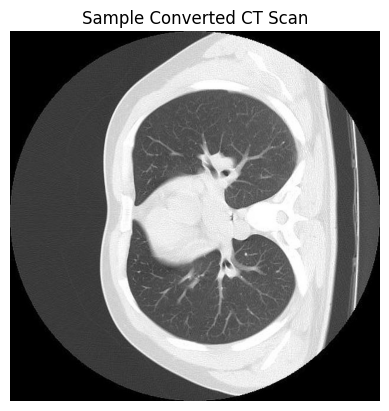

In [17]:
import matplotlib.pyplot as plt
import cv2

sample_image = cv2.imread(os.path.join(output_folder, os.listdir(output_folder)[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_image, cmap="gray")
plt.title("Sample Converted CT Scan")
plt.axis("off")
plt.show()


In [18]:
dataset_path = "converted_images"


In [22]:
import os

converted_folder = "converted_images"

# List all files and folders
print("Contents of converted_images folder:")
print(os.listdir(converted_folder))


Contents of converted_images folder:
['radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.png', 'radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.png', 'radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm.png', 'radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.png', 'coronacases_org_005.png', 'coronacases_org_007.png', 'radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.png', 'radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.png', 'coronacases_org_002.png', 'coronacases_org_006.png', 'coronacases_org_001.png', 'radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.png', 'coronacases_org_010.png', 'coronacases_org_004.png', 'radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm.png', 'coronacases_org_008.png', 'radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.png', 'coronacases_org_009.png', 'radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.png', 'coronacases_org_003.png']


In [24]:
import os

converted_folder = "converted_images"

# List all files and folders inside converted_images
print("Contents of converted_images folder:")
for item in os.listdir(converted_folder):
    print(f"📂 {item}")


Contents of converted_images folder:
📂 radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.png
📂 radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.png
📂 radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm.png
📂 radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.png
📂 coronacases_org_005.png
📂 coronacases_org_007.png
📂 radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.png
📂 radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.png
📂 coronacases_org_002.png
📂 coronacases_org_006.png
📂 coronacases_org_001.png
📂 radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.png
📂 coronacases_org_010.png
📂 coronacases_org_004.png
📂 radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm.png
📂 coronacases_org_008.png
📂 radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.png
📂 Infected
📂 coronacases_org_009.png
📂 radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.png
📂 coronacases_org_003.png


In [25]:
import os
import shutil

converted_folder = "converted_images"

# Define category folders
infected_folder = os.path.join(converted_folder, "Infected")
non_infected_folder = os.path.join(converted_folder, "Non-infected")

# Create category directories if they don't exist
os.makedirs(infected_folder, exist_ok=True)
os.makedirs(non_infected_folder, exist_ok=True)

# Move images based on naming patterns
for img in os.listdir(converted_folder):
    img_path = os.path.join(converted_folder, img)

    # Skip directories to prevent errors
    if os.path.isdir(img_path):
        continue

    # Categorize based on filename patterns
    if "radiopaedia" in img.lower() or "pneumonia" in img.lower():
        shutil.move(img_path, os.path.join(infected_folder, img))
    elif "coronacases" in img.lower():
        shutil.move(img_path, os.path.join(non_infected_folder, img))

print("✅ Images successfully categorized into 'Infected' and 'Non-infected'.")


✅ Images successfully categorized into 'Infected' and 'Non-infected'.


In [26]:
for category in ["Infected", "Non-infected"]:
    category_path = os.path.join(converted_folder, category)
    print(f"\n📂 {category_path}: {len(os.listdir(category_path))} images")



📂 converted_images/Infected: 11 images

📂 converted_images/Non-infected: 10 images


In [28]:
import shutil
import os

converted_folder = "converted_images"

# Ensure no nested directories exist
for category in ["Infected", "Non-infected"]:
    category_path = os.path.join(converted_folder, category)

    for item in os.listdir(category_path):
        item_path = os.path.join(category_path, item)

        # If a subdirectory is mistakenly placed, remove it
        if os.path.isdir(item_path):
            print(f"🚨 Removing incorrect directory: {item_path}")
            shutil.rmtree(item_path)

print("✅ Fixed nested folder issue.")


🚨 Removing incorrect directory: converted_images/Infected/Non-infected
✅ Fixed nested folder issue.


In [29]:
for category in ["Infected", "Non-infected"]:
    category_path = os.path.join(converted_folder, category)
    print(f"\n📂 {category_path}: {len(os.listdir(category_path))} images")



📂 converted_images/Infected: 10 images

📂 converted_images/Non-infected: 10 images


In [30]:
import shutil
import random

train_dir = "train"
val_dir = "val"

# Create directories for train/val
for category in ["Infected", "Non-infected"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to split data
def split_data(source, train_target, val_target, split_ratio=0.8):
    images = os.listdir(source)
    random.shuffle(images)

    train_size = int(len(images) * split_ratio)
    train_images = images[:train_size]
    val_images = images[train_size:]

    for img in train_images:
        shutil.copy(os.path.join(source, img), os.path.join(train_target, img))

    for img in val_images:
        shutil.copy(os.path.join(source, img), os.path.join(val_target, img))

# Perform split again
for category in ["Infected", "Non-infected"]:
    split_data(
        os.path.join("converted_images", category),
        os.path.join(train_dir, category),
        os.path.join(val_dir, category)
    )

print("✅ Data successfully split into training and validation sets.")


✅ Data successfully split into training and validation sets.


### Data Augmentation Comparison

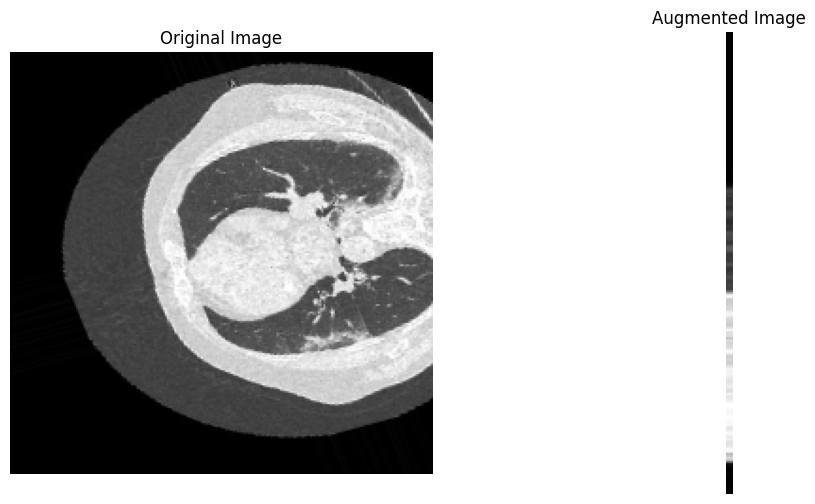

In [37]:
# Generate a single batch of images
sample_batch = train_generator.__next__()  # Use __next__() instead of next()
sample_image = sample_batch[0][0]  # Get first image from batch

# Plot original & augmented images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Augmented Image (Apply transformations)
# Create a new ImageDataGenerator instance with the same augmentation settings
aug_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Apply augmentation to the sample batch using aug_datagen.flow()
augmented_image = aug_datagen.flow(sample_batch[0], batch_size=1).__next__()[0][0]
plt.subplot(1, 2, 2)
plt.imshow(augmented_image, cmap="gray")
plt.title("Augmented Image")
plt.axis("off")

plt.show()

### Load Images Using ImageDataGenerator
We will now use ImageDataGenerator to:

Normalize images (scale pixel values between 0-1).
Apply data augmentation (rotation, zoom, shift) to improve generalization.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images in batches
batch_size = 32
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    "train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 18 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


### Display Sample Images from Each Class

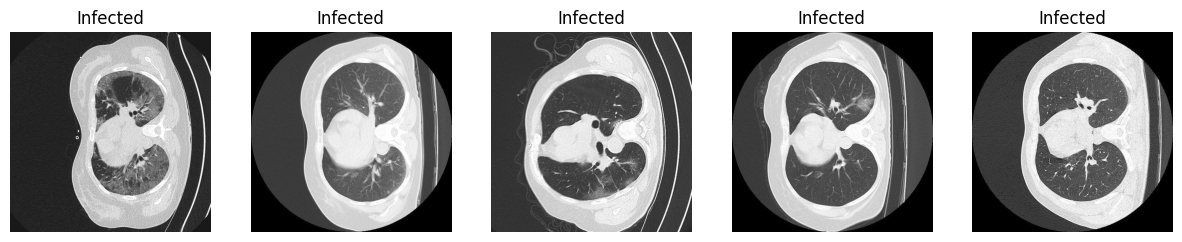

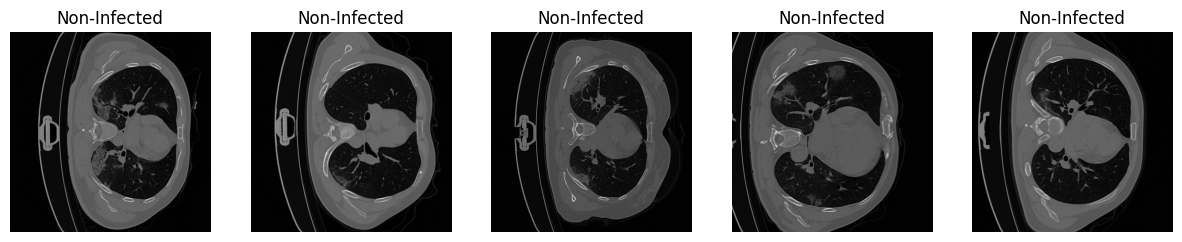

In [34]:
import matplotlib.pyplot as plt
import os
import cv2
import random

# Define dataset paths
infected_path = "converted_images/Infected"
non_infected_path = "converted_images/Non-infected"

# Function to display images
def display_sample_images(category_path, category_name):
    images = random.sample(os.listdir(category_path), 5)  # Pick 5 random images
    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(category_name)
        plt.axis("off")

# Show infected images
display_sample_images(infected_path, "Infected")

# Show non-infected images
display_sample_images(non_infected_path, "Non-Infected")

plt.show()


### Apply Transfer Learning (EfficientNetB0)
We use EfficientNetB0, a powerful pre-trained model.

In [33]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers correctly (Ensure proper connection)
x = base_model.output  # Get the output tensor of the base model
x = GlobalAveragePooling2D()(x)  # Apply global average pooling
x = Dense(128, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.3)(x)  # Apply dropout
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Define the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train the Model

In [38]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.5000 - loss: 0.7155 - val_accuracy: 0.5000 - val_loss: 0.7496
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5556 - loss: 0.7234 - val_accuracy: 0.5000 - val_loss: 0.7190
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5556 - loss: 0.7134 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5000 - loss: 0.7059 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4444 - loss: 0.7559 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3889 - loss: 0.7104 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4444 - loss: 0.7339 - val_accuracy: 0.5000 - val_loss: 0.7051
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4444 - loss: 0.7301 - val_accuracy: 0.5000 - val_loss: 

### Evaluate Model Performance

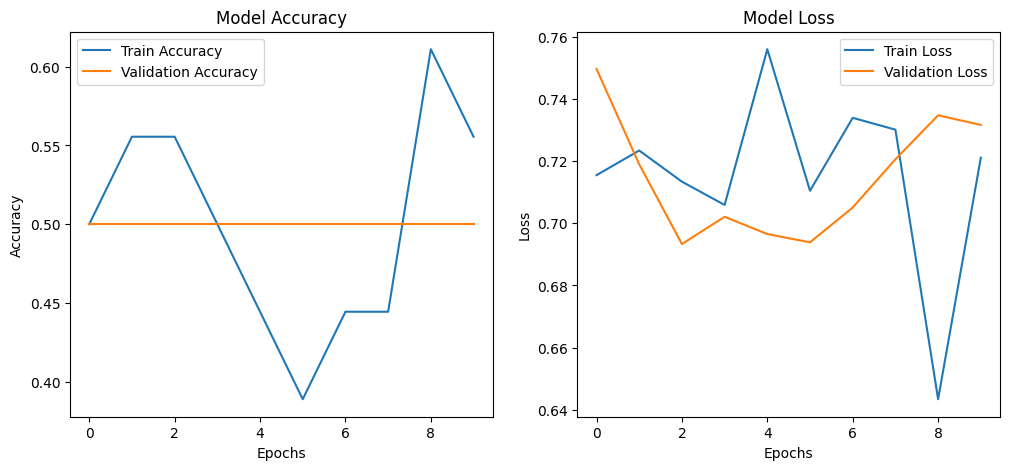

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


## Performance Comparison Between Transfer Learning Models

In [46]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add layers
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Define Model
resnet_final = Model(inputs=resnet_model.input, outputs=output_layer)

# Compile & Train
resnet_final.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
resnet_final.fit(train_generator, validation_data=val_generator, epochs=10)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5556 - loss: 0.9333 - val_accuracy: 0.5000 - val_loss: 0.6620
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3333 - loss: 0.7838 - val_accuracy: 0.7500 - val_loss: 0.6368
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7778 - loss: 0.6496 - val_accuracy: 0.7500 - val_loss: 0.6144
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6111 - loss: 0.6811 - val_accuracy: 0.7500 - val_loss: 0.5883
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7778 - loss: 0.5650 - val_accuracy: 0.5000 - val_loss: 0.5964
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.6667 - loss: 0.6156 - val_accuracy: 0.5000 - val_loss: 0.6292
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6111 - loss: 0.6161 - val_accuracy: 0.5000 - val_loss: 0.6361
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5556

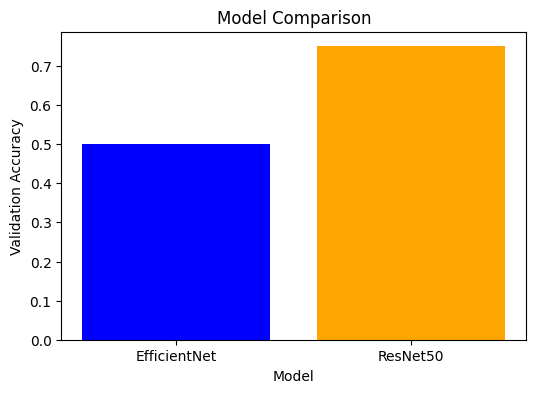

In [47]:
# Compare Model Performance
models = ["EfficientNet", "ResNet50"]
accuracies = [history.history["val_accuracy"][-1], resnet_final.history.history["val_accuracy"][-1]]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=["blue", "orange"])
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison")
plt.show()


### Generate Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


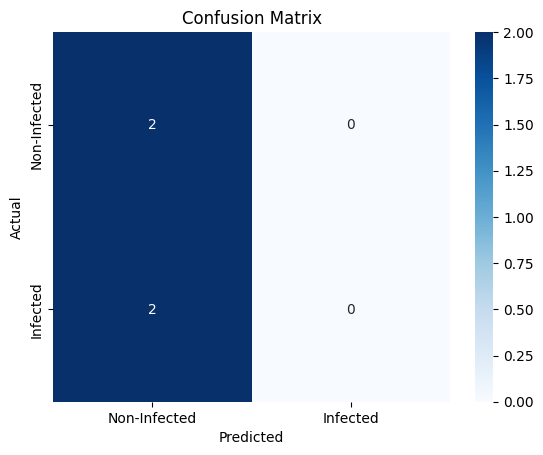

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

# Print classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Infected", "Infected"], yticklabels=["Non-Infected", "Infected"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Class Distribution Plot (Before Training)

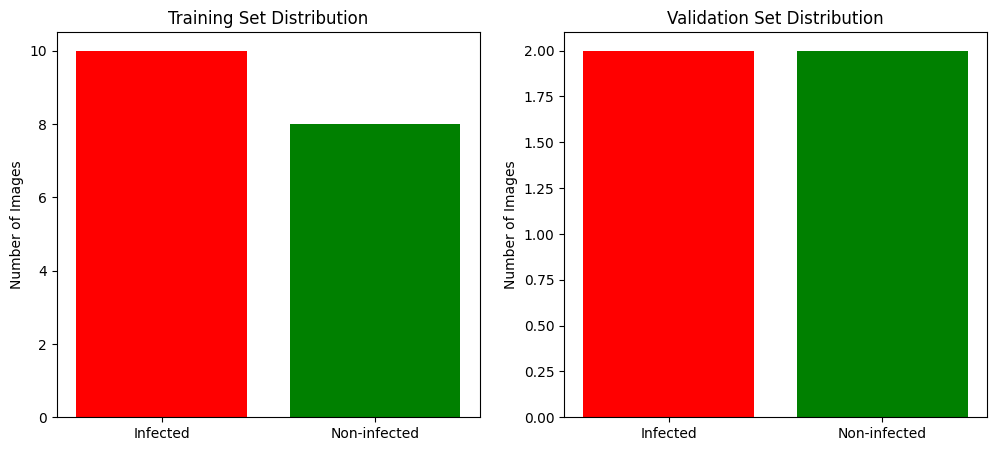

In [53]:
import matplotlib.pyplot as plt
import os

# Count images in each class
train_counts = {c: len(os.listdir(f"train/{c}")) for c in ["Infected", "Non-infected"]}
val_counts = {c: len(os.listdir(f"val/{c}")) for c in ["Infected", "Non-infected"]}

labels = ["Infected", "Non-infected"]
train_sizes = list(train_counts.values())
val_sizes = list(val_counts.values())

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training Set Distribution
ax[0].bar(labels, train_sizes, color=["red", "green"])
ax[0].set_title("Training Set Distribution")
ax[0].set_ylabel("Number of Images")

# Validation Set Distribution
ax[1].bar(labels, val_sizes, color=["red", "green"])
ax[1].set_title("Validation Set Distribution")
ax[1].set_ylabel("Number of Images")

plt.show()


## Accuracy and Loss Curves (Training Progress)

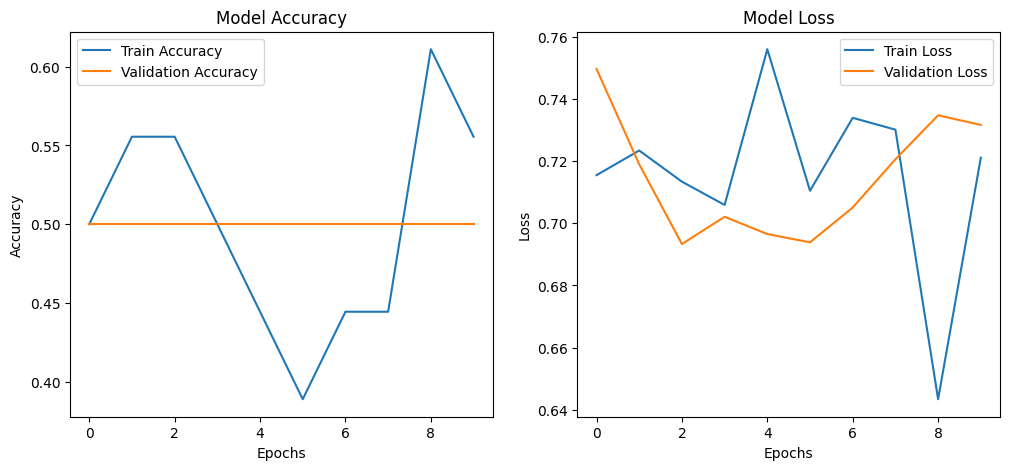

In [54]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


## ROC Curve (Model Confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


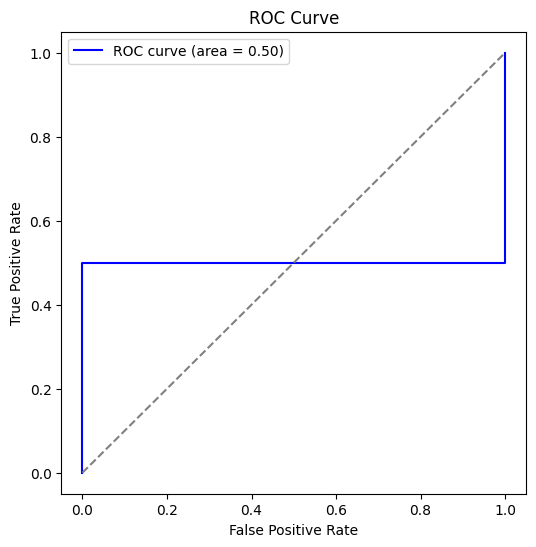

In [56]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for ROC Curve
y_probs = model.predict(val_generator).ravel()
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


### Make Predictions on New Images

In [49]:
from google.colab import files

# Upload a file manually
uploaded = files.upload()

# Get the uploaded file name
img_path = list(uploaded.keys())[0]
print("Uploaded file:", img_path)


Saving vvv.png to vvv (1).png
Uploaded file: vvv (1).png


In [50]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the uploaded image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]
print("Prediction:", "Infected" if prediction > 0.5 else "Non-Infected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Non-Infected


## Test with another image

In [51]:
from google.colab import files

# Upload a file manually
uploaded = files.upload()

# Get the uploaded file name
img_path = list(uploaded.keys())[0]
print("Uploaded file:", img_path)

Saving Capture-2025-02-25-232601.png to Capture-2025-02-25-232601 (1).png
Uploaded file: Capture-2025-02-25-232601 (1).png


In [52]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the uploaded image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]
print("Prediction:", "Infected" if prediction > 0.5 else "Non-Infected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Non-Infected
